In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import copy
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

%load_ext tensorboard

In [2]:
# reading the data into data frames using pandas
"""
data_csv is a list of 10 data frames holding a [2,] list for each symboL
the first one (for example data_csv[i][0] ) is the name of the symbol and
the second one (for example data_csv[i][1] ) is the data assosiated to it
"""
data_csv = []
i = 0
for filename in glob.glob('data/*.csv'):
    data_csv.append([filename[5:len(filename)-4],pd.read_csv(filename).drop("<TICKER>",1)])
    i+=1
# print(data_csv[0][0])
# data_csv[0][1].head()

In [3]:
data_frame = 2
features = data_csv[data_frame][1][['<OPEN>', '<CLOSE>', '<HIGH>', '<CLOSE>', '<VOL>']]
# features.index = data_csv[data_frame][1]['<DTYYYYMMDD>']
features.head()
# print(features.shape)
# features.plot(subplots=True)

,<OPEN>,<CLOSE>,<HIGH>,<CLOSE>,<VOL>
0,4000.0,3704.0,4000.0,3704.0,172898994
1,3778.0,3778.0,3778.0,3778.0,10826496
2,3853.0,3853.0,3853.0,3853.0,26850133
3,3930.0,3930.0,3930.0,3930.0,31086849
4,4008.0,4008.0,4008.0,4008.0,40645528


In [4]:
def trun_to_windows(input,kernel):
    """
    Suppose that input is (T, F): T is the number of time steps and F is the number of features
    Then this function creates a list of data, label pairs in which data is (N, K, F) and label is (N, F)
    N is the number of data, label pairs

    Inputs:
    - input: (T, F)
    - kernel: scalar and we call it K

    Outputs:
    - data: (N, K, F)
    - labels: (N, F)
    """
    data = []
    labels = []
    for i in range(0,len(input)-kernel):
        data.append(input[i:i+kernel])
        labels.append(input[i+kernel])
    return np.array(data),np.array(labels)

In [5]:
data,labels = trun_to_windows(features.values,20)
data_std = np.std(data, axis=0)
data_mean = np.mean(data, axis=0)
labels_std = np.std(labels, axis=0)
labels_mean = np.mean(labels, axis=0)
# data_back = copy.deepcopy(data)
# labels_back = copy.deepcopy(labels)
print(data.shape)
print(labels.shape)
# normalize
data = (data - data_mean) / data_std
labels = (labels - labels_mean) / labels_std

(3026, 20, 5)
(3026, 5)


In [6]:
"""
In this section we define some hyperparameters
and later use it in tensorboard. 
"""
HP_LSTM1_OUT = hp.HParam('lstm1_out', hp.Discrete([100, 50]))
HP_LSTM2_OUT = hp.HParam('lstm2_out', hp.Discrete([20, 10]))
METRIC = 'loss'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_LSTM1_OUT, HP_LSTM2_OUT],
        metrics=[hp.Metric(METRIC, display_name='Loss')],
    )

In [10]:
def train_eval_model(hparams):
    """
    This function creates and trains a model with given hyperparameters 
    and returns the final loss.
    """

    model = keras.Sequential([
        keras.layers.LSTM(hparams[HP_LSTM1_OUT], activation='relu', input_shape=data[0].shape, return_sequences=True),
        keras.layers.LSTM(hparams[HP_LSTM2_OUT], activation='relu'),
        keras.layers.Dense(labels.shape[1])
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(data,labels,epochs=20,batch_size=32)
    loss = model.evaluate(data, labels)
    return loss, model

def run(run_dir, hparams):
    """
    This function tests one set of hyperparameters
    and saves the result in log directory.
    """
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)                                         # record the values used in this trial
        loss, _ = train_eval_model(hparams)
        tf.summary.scalar('loss', loss, step=1)

In [17]:
"""
In this section we try all different combinations of hyperparameters
and save the results.
Later we can use tensorboard to visualize these logs.
"""
session_num = 0
for lstm1_out in HP_LSTM1_OUT.domain.values:
    for lstm2_out in HP_LSTM2_OUT.domain.values:
        hparams = {
            HP_LSTM1_OUT: lstm1_out,
            HP_LSTM2_OUT: lstm2_out
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

In [11]:
"""
After testing hyperparameters now its time to
train the model with the best set of hyperparameters.
"""
hparams = {
    HP_LSTM1_OUT: 50,
    HP_LSTM2_OUT: 10
}
loss, model = train_eval_model(hparams)
print('best model has loss:', loss)

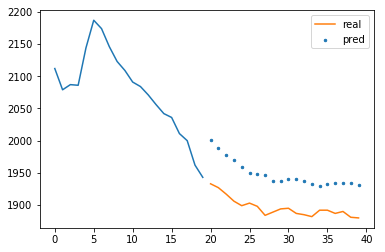

In [23]:
"""
In this section we visualize the results for a random test case.
"""
pred = []
i = 1900
pred = model.predict(data[i:i+20].reshape(-1, 20, 5))
un_data = data * data_std + data_mean
un_labels = labels * labels_std + labels_mean
un_pred = pred * labels_std + labels_mean

plt.plot(range(20), list(un_data[i, :, 3]))
plt.scatter(range(20,40), list(un_pred[:, 0]), s=6, label='pred')
plt.plot(range(20,40), list(un_data[20+i, :, 3]), label='real')
plt.legend()